In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Import dependencies
from collections import OrderedDict
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.init as init

import psutil
from torchsummary import summary
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

In [19]:
# Download MNIST dataset
data_train = MNIST(
    "./data/mnist", download=True, 
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=1),
        transforms.ToTensor()
    ])
)
        
data_test = MNIST(
    "./data/mnist", download=True, train=False,
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
)

In [25]:
# Define hyperparameters
EPOCHS = 20
BATCH_SIZE = 512
DROPOUT_PROB = 0.2
USE_BATCHNORM = True

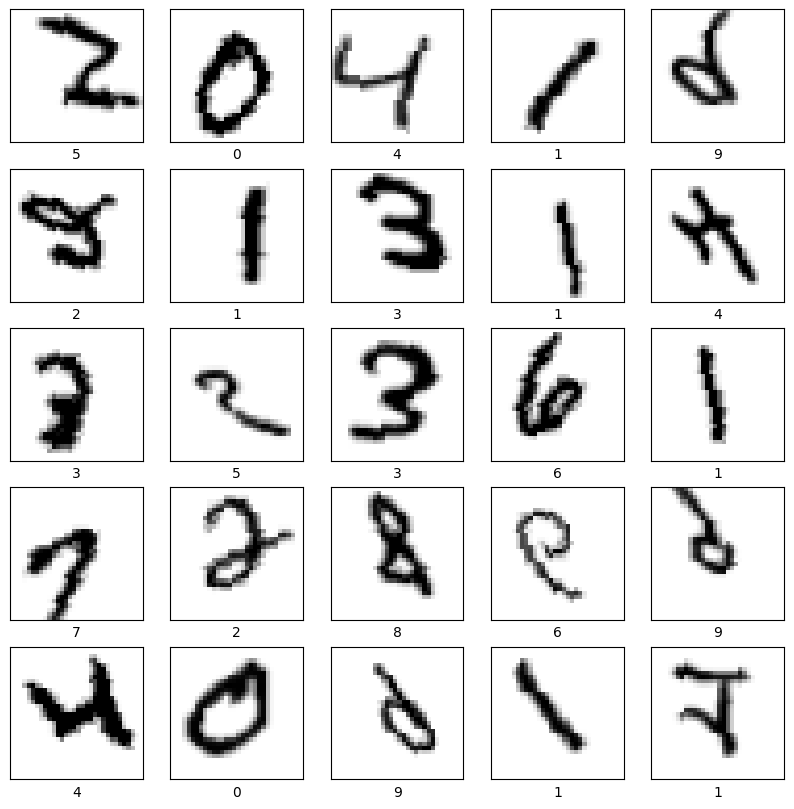

In [26]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i][0].permute(1,2,0).numpy(), cmap=plt.cm.binary)
    plt.xlabel(data_train[i][1])
plt.show()

`torch.utils.data.DataLoader` supports asynchronous data loading and data augmentation in separate worker subprocesses. The default setting for DataLoader is `num_workers=0`, which means that the data loading is synchronous and done in the main process. As a result the main training process has to wait for the data to be available to continue the execution.

Settin`g num_workers >` 0 enables asynchronous data loading and overlap between the training and data loading. num_workers should be tuned depending on the workload, CPU, GPU, and location of training data.`

DataLo`ader acce`pts pin_me`mory argument, which defaults` to F`alse. When using a GPU it’s better to `set pin_memory=`True, this instru`cts DataLo`ader to use pinned memory and enables faster and asynchronous memory copy from the host to the GPU.

In [27]:
def calculate_num_workers():
    # Calculate the number of CPU cores
    num_cpu_cores = os.cpu_count()

    # Set a safe maximum multiplier value (e.g., 0.5) to avoid using all available resources
    max_multiplier = 0.5

    # Calculate the number of workers based on the available resources
    multiplier = min(sum(psutil.cpu_percent(interval=1, percpu=True)) / 100.0, max_multiplier)
    
    # Ensure that num_workers is at least 1
    num_workers = max(1, int(num_cpu_cores * multiplier))

    return num_workers

In [28]:
# Define train dataloader
train_dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=calculate_num_workers())

# Define test dataloader
test_dataloader = DataLoader(data_test, batch_size=BATCH_SIZE, pin_memory=True, num_workers=calculate_num_workers())

`torch.nn.Conv2d()` has `bias` parameter which defaults to `True` (the same is true for `Conv1d` and `Conv3d` ).

If a `nn.Conv2d` layer is directly followed by a `nn.BatchNorm2d` layer, then the bias in the convolution is not needed, instead use `nn.Conv2d(..., bias=False, ....)`. Bias is not needed because in the first step `BatchNorm` subtracts the mean, which effectively cancels out the effect of bias.

This is also applicable to 1d and 3d convolutions as long as `BatchNorm`(or other normalization layer) normalizes on the same dimension as convolution’s bias.

In [29]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
                
        self.features1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5), bias=not USE_BATCHNORM),
            self._get_norm_layer(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout2d(p=DROPOUT_PROB)
        )
        
        self.features2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=(5, 5), bias=not USE_BATCHNORM),
            self._get_norm_layer(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout2d(p=DROPOUT_PROB)
        )

        self.features3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=(5, 5), bias=not USE_BATCHNORM),
            self._get_norm_layer(120),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT_PROB)
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84, bias=True),
            nn.ReLU(),
            nn.Dropout(p=DROPOUT_PROB),
            nn.Linear(84, 10, bias=True)
        )

        # Initialize layers
        self.apply(self._initialize_weights)

    def _get_norm_layer(self, channels):
        if USE_BATCHNORM:
            return nn.BatchNorm2d(channels)
        else:
            return nn.Identity()

    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.kaiming_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Instantiate the model
model = LeNet()
model = model.to(device)

# Test with a random input
summary(model, input_size=(1, 32, 32), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [512, 6, 28, 28]             150
       BatchNorm2d-2           [512, 6, 28, 28]              12
              ReLU-3           [512, 6, 28, 28]               0
         MaxPool2d-4           [512, 6, 14, 14]               0
         Dropout2d-5           [512, 6, 14, 14]               0
            Conv2d-6          [512, 16, 10, 10]           2,400
       BatchNorm2d-7          [512, 16, 10, 10]              32
              ReLU-8          [512, 16, 10, 10]               0
         MaxPool2d-9            [512, 16, 5, 5]               0
        Dropout2d-10            [512, 16, 5, 5]               0
           Conv2d-11           [512, 120, 1, 1]          48,000
      BatchNorm2d-12           [512, 120, 1, 1]             240
             ReLU-13           [512, 120, 1, 1]               0
        Dropout2d-14           [512, 12

In [32]:
# Initialize loss
criterion = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = optim.Adam(model.parameters())

In [33]:
def train(epoch):
    model.train()
    total_loss = 0.0

    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch}/Training", unit="batch") as pbar:
        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix(loss=total_loss / (i+1))
    
    avg_loss = total_loss / len(train_dataloader.dataset)
    print(f"[Train][Epoch {epoch}] Average Loss: {avg_loss:.5f}")

In [34]:
def test(epoch):
    model.eval()
    total_correct = 0
    total_loss = 0.0

    with tqdm(total=len(test_dataloader), desc=f"Epoch {epoch}/Testing", unit="batch") as pbar: 
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_dataloader):
                images, labels = images.to(device), labels.to(device)
                
                output = model(images)                
                loss = criterion(output, labels)

                total_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix(loss=total_loss / (i+1))
                
                pred = output.detach().max(1)[1]
                total_correct += pred.eq(labels.view_as(pred)).sum()
            
    avg_loss = total_loss / len(test_dataloader.dataset)
    accuracy = total_correct / len(test_dataloader.dataset)
    
    print(f"[Test][Epoch {epoch}] Loss: {avg_loss:.5f}, Accuracy: {accuracy:3f}")
    return avg_loss

In [35]:
def run():
    for epoch in range(EPOCHS):
        train(epoch)
        val_loss = test(epoch)

In [36]:
run()

Epoch 0/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 0] Average Loss: 0.00347


Epoch 0/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 0] Loss: 0.00135, Accuracy: 0.809300


Epoch 1/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 1] Average Loss: 0.00217


Epoch 1/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 1] Loss: 0.00073, Accuracy: 0.898300


Epoch 2/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 2] Average Loss: 0.00164


Epoch 2/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 2] Loss: 0.00049, Accuracy: 0.930100


Epoch 3/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 3] Average Loss: 0.00138


Epoch 3/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 3] Loss: 0.00041, Accuracy: 0.942100


Epoch 4/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 4] Average Loss: 0.00121


Epoch 4/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 4] Loss: 0.00035, Accuracy: 0.947900


Epoch 5/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 5] Average Loss: 0.00109


Epoch 5/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 5] Loss: 0.00031, Accuracy: 0.952200


Epoch 6/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 6] Average Loss: 0.00100


Epoch 6/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 6] Loss: 0.00027, Accuracy: 0.958100


Epoch 7/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 7] Average Loss: 0.00093


Epoch 7/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 7] Loss: 0.00025, Accuracy: 0.959700


Epoch 8/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 8] Average Loss: 0.00088


Epoch 8/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 8] Loss: 0.00024, Accuracy: 0.960000


Epoch 9/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 9] Average Loss: 0.00083


Epoch 9/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 9] Loss: 0.00024, Accuracy: 0.961100


Epoch 10/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 10] Average Loss: 0.00080


Epoch 10/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 10] Loss: 0.00022, Accuracy: 0.964000


Epoch 11/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 11] Average Loss: 0.00077


Epoch 11/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 11] Loss: 0.00020, Accuracy: 0.967100


Epoch 12/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 12] Average Loss: 0.00074


Epoch 12/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 12] Loss: 0.00018, Accuracy: 0.970100


Epoch 13/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 13] Average Loss: 0.00072


Epoch 13/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 13] Loss: 0.00019, Accuracy: 0.967800


Epoch 14/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 14] Average Loss: 0.00069


Epoch 14/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 14] Loss: 0.00017, Accuracy: 0.972000


Epoch 15/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 15] Average Loss: 0.00068


Epoch 15/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 15] Loss: 0.00018, Accuracy: 0.968800


Epoch 16/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 16] Average Loss: 0.00066


Epoch 16/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 16] Loss: 0.00017, Accuracy: 0.972200


Epoch 17/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 17] Average Loss: 0.00066


Epoch 17/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 17] Loss: 0.00018, Accuracy: 0.969900


Epoch 18/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 18] Average Loss: 0.00063


Epoch 18/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 18] Loss: 0.00017, Accuracy: 0.971100


Epoch 19/Training:   0%|          | 0/118 [00:00<?, ?batch/s]

[Train][Epoch 19] Average Loss: 0.00062


Epoch 19/Testing:   0%|          | 0/20 [00:00<?, ?batch/s]

[Test][Epoch 19] Loss: 0.00016, Accuracy: 0.974100
